In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("games.csv")
df

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20053,EfqH7VVH,True,1.499791e+12,1.499791e+12,24,resign,white,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,Dutch Defense,2
20054,WSJDhbPl,True,1.499698e+12,1.499699e+12,82,mate,black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,Queen's Pawn,2
20055,yrAas0Kj,True,1.499698e+12,1.499698e+12,35,mate,white,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,Queen's Pawn Game: Mason Attack,3
20056,b0v4tRyF,True,1.499696e+12,1.499697e+12,109,resign,white,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,Pirc Defense,4


In [3]:
# Check number of null values of each column
df.isna().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

In [4]:
# Convert created_at and last_move_at from interger to datetime
df['created_at']    = pd.to_datetime(df['created_at']/1000,  unit='s',  origin='unix')
df['last_move_at']  = pd.to_datetime(df['last_move_at']/1000,  unit='s',  origin='unix')
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [5]:
df['duration'] = (df['last_move_at'] - df['created_at']).dt.total_seconds()
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,duration
0,TZJHLljE,False,2017-08-31 20:06:40,2017-08-31 20:06:40,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,0.0
1,l1NXvwaE,True,2017-08-30 21:53:20,2017-08-30 21:53:20,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,0.0
2,mIICvQHh,True,2017-08-30 21:53:20,2017-08-30 21:53:20,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,0.0
3,kWKvrqYL,True,2017-08-30 16:20:00,2017-08-30 16:20:00,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,0.0
4,9tXo1AUZ,True,2017-08-29 18:06:40,2017-08-29 18:06:40,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,0.0


In [6]:
print(f"Number of unique white players: {len(df['white_id'].unique())}")
print(f"Number of unique black players: {len(df['black_id'].unique())}")
print(f"Number of unique players: {len(set(df['white_id'].unique()) | set(df['black_id'].unique()))}")
print(f"Number of unique players who had played both black and white: {len(set(df['white_id'].unique()) & set(df['black_id'].unique()))}")

Number of unique white players: 9438
Number of unique black players: 9331
Number of unique players: 15635
Number of unique players who had played both black and white: 3134


In [7]:
df['opening_name'].value_counts()

Van't Kruijs Opening                                              368
Sicilian Defense                                                  358
Sicilian Defense: Bowdler Attack                                  296
Scotch Game                                                       271
French Defense: Knight Variation                                  271
                                                                 ... 
Sicilian Defense: Kupreichik Variation                              1
Modern Defense: Lizard Defense |  Mittenberger Gambit               1
French Defense: Rubinstein Variation |  Kasparov Attack             1
French Defense: Tarrasch Variation |  Open System |  Main Line      1
Sicilian Defense: Najdorf Variation |  Polugaevsky Variation        1
Name: opening_name, Length: 1477, dtype: int64

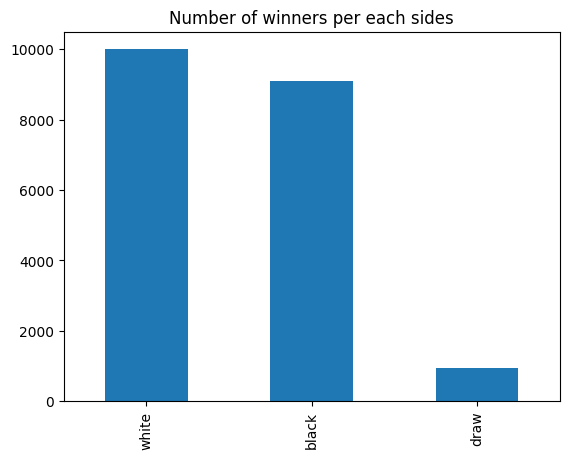

In [8]:
df['winner'].value_counts().plot.bar()
plt.title("Number of winners per each sides")
plt.show()

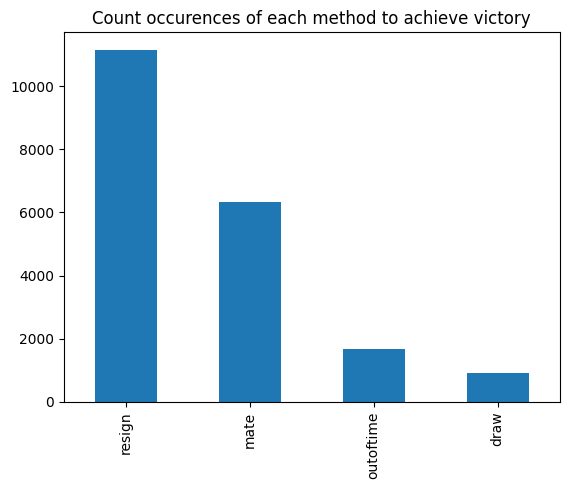

In [9]:
df['victory_status'].value_counts().plot.bar()
plt.title("Count occurences of each method to achieve victory")
plt.show()

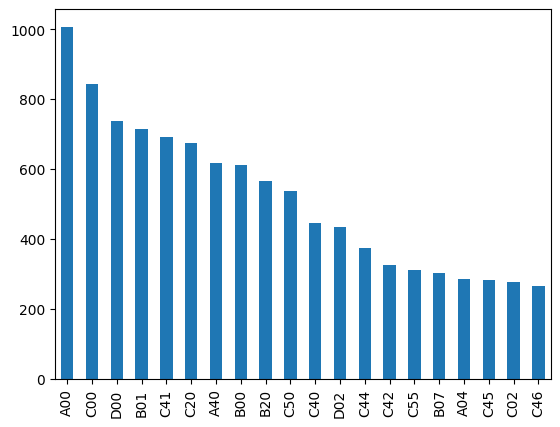

In [39]:
df['opening_eco'].value_counts()[:20].plot.bar()
plt.show()

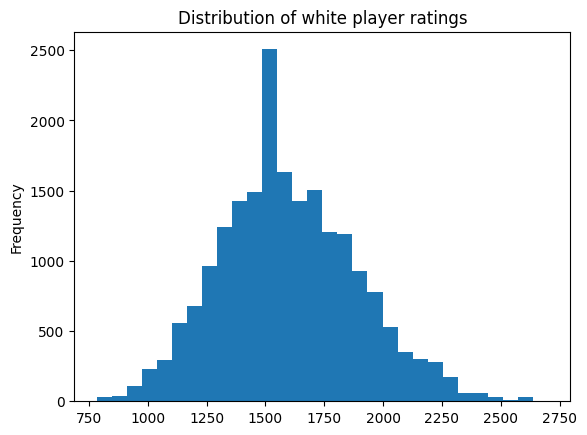

In [10]:
df['white_rating'].plot.hist(bins=30)
plt.title('Distribution of white player ratings')
plt.show()

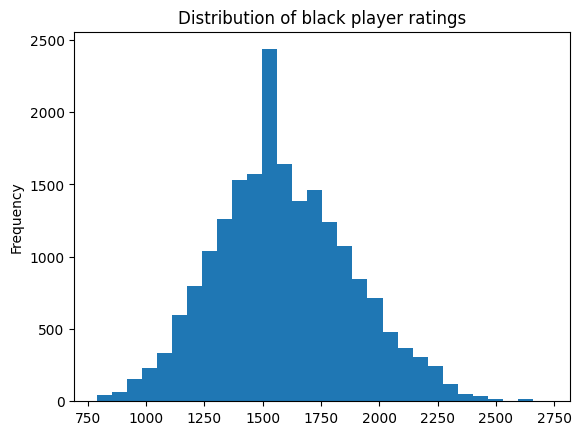

In [11]:
df['black_rating'].plot.hist(bins=30)
plt.title('Distribution of black player ratings')
plt.show()

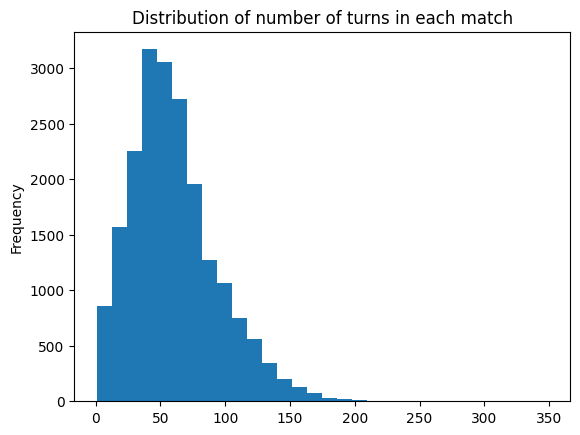

In [12]:
df['turns'].plot.hist(bins=30)
plt.title('Distribution of number of turns in each match')
plt.show()

In [33]:
df_player = pd.DataFrame({"player_id": list(set(df['white_id'].unique()) | set(df['black_id'].unique()))})

In [36]:
# Get only matches in which black wins
black_win = df[df['winner'] == 'black']
white_win = df[df['winner'] == 'white']

# Get number of matches that a player participated
df_player['matches_participated'] = df_player['player_id'].map(
    df['white_id'].value_counts().add(df['black_id'].value_counts(), fill_value=0))

# Get number of wins per each player when playing as black, white, overall
df_player['wins_as_black'] = df_player['player_id'].map(black_win['black_id'].value_counts()).fillna(0)
df_player['wins_as_white'] = df_player['player_id'].map(white_win['white_id'].value_counts()).fillna(0)
df_player['wins'] = df_player['wins_as_black'] + df_player['wins_as_white']

# Wins to matches participated ratio
df_player['wins_percentage'] = df_player['wins'] / df_player['matches_participated']
df_player.head(10)

,player_id,matches_participated,wins_as_black,wins_as_white,wins,wins_percentage
0,sam4923,1.0,0.0,1.0,1.0,1.000000
1,fmtabriz,9.0,1.0,3.0,4.0,0.444444
2,tireddoc,1.0,1.0,0.0,1.0,1.000000
3,alanoytoro,2.0,1.0,1.0,2.0,1.000000
4,nitheshgudar,1.0,0.0,0.0,0.0,0.000000
5,enterrador,2.0,1.0,1.0,2.0,1.000000
6,pombeira,1.0,0.0,0.0,0.0,0.000000
7,al-ol-da55,2.0,0.0,1.0,1.0,0.500000
8,closed_guard,1.0,0.0,0.0,0.0,0.000000
9,mark2010,1.0,1.0,0.0,1.0,1.000000
